### 1 Loading Dataset

In [6]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/Project/model1and2/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!/opt/bin/nvidia-smi

Mon Jan 24 11:29:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from my_datasets import MyDataset
from my_models import MyModel
from data.model_input_all import state_on, input_0, input_4, input_5, input_6
from data.model_gt_all import label_on,label_0, label_4, label_5, label_6

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [10]:
# gather all data
input_all = np.concatenate((state_on, input_0, input_4, input_5, input_6), axis = 0) 
print(input_all.shape) 
label_all = np.concatenate((label_on,label_0, label_4, label_5, label_6), axis = 0)
print(label_all.shape) 
data_all = np.zeros((input_all.shape[0], 7)) 
data_all[:,0] = input_all[:,4] - input_all[:,0]
data_all[:,1] = input_all[:,5] - input_all[:,1]
data_all[:,2] = input_all[:,6] - input_all[:,2]
data_all[:,3] = input_all[:,3]
data_all[:,4] = input_all[:,7]
data_all[:,5:] = label_all
np.random.shuffle(data_all)
print(data_all.shape)
print(data_all[0])

(30800, 8)
(30800, 2)
(30800, 7)
[ 6.65045929 -3.0562439  -0.04300366  4.93891158  4.68660979  0.68872645
  0.1014157 ]


In [11]:
def split_dataset(data, split_list):
    print(data.shape)
    split_num = data.shape[0] * np.array(split_list)
    print(split_num)
    return data[:round(split_num[0]), :], data[round(split_num[0]):round(split_num[1]+split_num[0]), :], data[round(split_num[1]+split_num[0]):, :]

split_list = [0.7, 0.2, 0.1]
train_input, val_input, test_input = split_dataset(data_all[:, :5], split_list)
train_label, val_label, test_label = split_dataset(data_all[:, 5:], split_list) 
print('train input shape', train_input.shape)

(30800, 5)
[21560.  6160.  3080.]
(30800, 2)
[21560.  6160.  3080.]
train input shape (21560, 5)


In [12]:
# test_dataset with only one sample for overfitting
over_input = data_all[:2, :5]
over_label = data_all[:2, 5:]

train_data = MyDataset(states = train_input, labels = train_label)
val_data = MyDataset(states = val_input, labels = val_label)
test_data = MyDataset(states = test_input, labels = test_label)
over_data = MyDataset(states = over_input, labels = over_label)   

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=True)
over_loader = DataLoader(dataset=over_data, batch_size=2, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Test size: %i" % len(test_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)

Train size: 21560
Validation size: 6160
Test size: 3080
Input size:  (5,)
Label size:  (2,)


### 2 Defining Neural Network

In [37]:
mynet = MyModel(neurons = [256, 512, 1024, 512, 256]) 
print(mynet)

MyModel(
  (predictor): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [38]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

1,320,962 total parameters.
1,320,962 trainable parameters.


### 3 Training Neural network

In [30]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 

In [31]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0  
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = X.cuda()
        y = y.cuda()
        #print(i)
        if iftrain:  
            #model.train()
            optimizer.zero_grad()
            y_pred = model(X.to(torch.float32))
            #y_pred[:,1] = y_pred[:,1] * 20
            #y[:,1] = y[:,1] * 20
            y_pred = y_pred.float()
            y = y.float() 
            
            loss = criterion(y_pred, y)  
            loss.backward()             
            optimizer.step()            
            running_loss += loss.item() 
        else:
            #model.eval()
            y_pred = model(X.to(torch.float32))
            y_pred = y_pred.float()  
            y = y.float()
            #y_pred[:,1] = y_pred[:,1] * 20
            #y[:,1] = y[:,1] * 20 
            loss = criterion(y_pred , y)  
            running_loss += loss.item()    
    return running_loss    

In [32]:
# test if the model will overfit with only one sample
max_epochs = 1000 
train_history = []
val_history = []

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 50 == 49:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss/5, val_loss/5))

RuntimeError: ignored

In [ ]:
# test inference 
for i, data in enumerate(over_loader, 0): 
        print(data)
        X = torch.tensor(data[0]).cuda()
        y = torch.tensor(data[1]).cuda()
        y_pred = mynet(X.to(torch.float32))
        if i < 10:
            print('test',i)
            print('prediction: {},\nground truth：{}'.format(y_pred/10, y/10)) 

[tensor([[12.4576, -9.5441,  0.0244, 11.3337,  8.4616],
        [ 8.3376, -6.6653, -0.0260,  4.9277,  5.8813]], dtype=torch.float64), tensor([[10.0000,  0.0122],
        [10.0000,  2.8510]], dtype=torch.float64)]
test 0
prediction: tensor([[1.0000, 0.0012],
        [1.0000, 0.2851]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([[1.0000, 0.0012],
        [1.0000, 0.2851]], device='cuda:0', dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


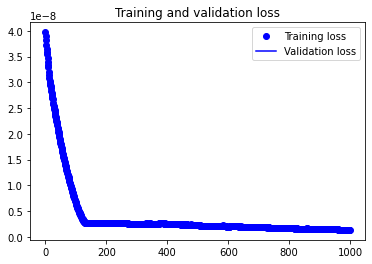

In [ ]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=2e-6, eps = 1e-08) 

In [ ]:
# start the main training process
max_epochs = 1000
print('train_data',len(train_data))
num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 5

print('Start training!')

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    if epoch % 2 == 1:
      print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
          (train_loss/num_trainbatch, val_loss/num_valbatch))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

train_data 21560
Start training!
Epoch   2/1000, train_loss: 8.451576e-04, val_loss: 3.163411e+00 
Epoch   4/1000, train_loss: 8.361415e-04, val_loss: 3.354223e+00 
Epoch   6/1000, train_loss: 8.417031e-04, val_loss: 3.286757e+00 
Epoch   8/1000, train_loss: 8.697682e-04, val_loss: 3.157284e+00 
Epoch  10/1000, train_loss: 8.481015e-04, val_loss: 3.237529e+00 
Epoch  12/1000, train_loss: 8.443023e-04, val_loss: 3.179889e+00 
Epoch  14/1000, train_loss: 8.618788e-04, val_loss: 3.249718e+00 
Epoch  16/1000, train_loss: 8.550018e-04, val_loss: 3.171545e+00 
Epoch  18/1000, train_loss: 8.323403e-04, val_loss: 3.198881e+00 
Epoch  20/1000, train_loss: 8.236991e-04, val_loss: 3.205657e+00 
Epoch  22/1000, train_loss: 8.720227e-04, val_loss: 3.463562e+00 
Epoch  24/1000, train_loss: 8.778780e-04, val_loss: 3.218102e+00 
Epoch  26/1000, train_loss: 8.379135e-04, val_loss: 3.175299e+00 
Epoch  28/1000, train_loss: 8.375261e-04, val_loss: 3.163019e+00 
Epoch  30/1000, train_loss: 8.515796e-04, v

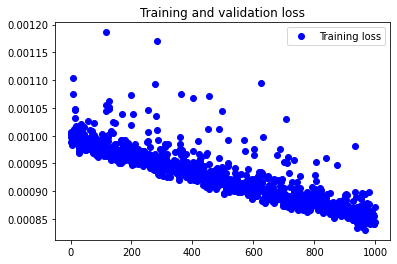

In [ ]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
#plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [ ]:
# save trained model
torch.save(mynet.state_dict(),'/content/drive/My Drive/model/mynet2_10.pth')

In [ ]:
mynet.load_state_dict(torch.load('/content/drive/My Drive/model/mynet2_4.pth'))

<All keys matched successfully>

In [ ]:
# test inference 
test_loss = 0
for n, data in enumerate(test_loader): 
        X = torch.tensor(data[0]).cuda() 
        y = torch.tensor(data[1]).cuda()
        if n < 2:
          for i, x in enumerate(X): 
            mynet.eval()
            x = x[None, :]
            y_pred = mynet(x.to(torch.float32)) 
            if i < 20:
              print('test',i)
              print('prediction  : {},\nground truth：{}'.format(y_pred/10, y[i]/10)) 
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


test 0
prediction  : tensor([[-0.0051, -0.0307]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 3.8322e-14, -2.4431e-02], device='cuda:0', dtype=torch.float64)
test 1
prediction  : tensor([[ 0.0014, -0.0521]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 7.6854e-14, -4.4376e-02], device='cuda:0', dtype=torch.float64)
test 2
prediction  : tensor([[ 0.9995, -0.0195]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 1.0000, -0.0243], device='cuda:0', dtype=torch.float64)
test 3
prediction  : tensor([[0.6516, 0.0921]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 0.6759, -0.0190], device='cuda:0', dtype=torch.float64)
test 4
prediction  : tensor([[ 0.7912, -0.0080]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 0.7330, -0.0099], device='cuda:0', dtype=torch.float64)
test 5
prediction  : tensor([[ 0.0324, -0.1099]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 7.0853e-18, -2.2659e-0